In [1]:
# 13:12 17/3/2023: 14.51
# https://www.kaggle.com/code/krishnaprasad96/siamese-network
# https://towardsdatascience.com/siamese-networks-line-by-line-explanation-for-beginners-55b8be1d2fc6
# https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee

# !pip install keras
# !pip install keras_utils
# !pip install plot_model
# !pip install hdbscan
# !pip install ipympl

import os, sys
import matplotlib.pyplot as plt, numpy as np
from PIL import Image
from matplotlib import markers
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set_theme()
sns.reset_orig()

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda #, merge
from keras.layers import InputLayer, UpSampling2D, Concatenate, Reshape, Embedding, dot
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from keras import backend as K
# from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from sklearn.cluster import MeanShift, estimate_bandwidth
# from sklearn.cluster import KMeans
# import sklearn.cluster as cluster
# from itertools import cycle
# from scipy import spatial
# from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
def contrastive_loss(y, preds, margin=4):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

#Building a sequential model
input_shape=(320, 240, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), strides=2, activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init,
                        kernel_regularizer=l2(2e-4)), #(10, 10)
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2), #(1,2)
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),

    keras.layers.Dense(1024, activation='relu', kernel_initializer=W_init, bias_initializer=b_init,kernel_regularizer=l2(2e-4)),
    keras.layers.Dense(12, activation='linear', kernel_initializer=W_init, bias_initializer=b_init) # "sigmoid"
])

encoded_l = model(left_input)
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_layer = Lambda(lambda tensors:tensors[0] - tensors[1])

# subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
L1_distance = L1_layer([encoded_l, encoded_r])

vector_norm = keras.layers.dot([L1_distance, L1_distance], axes=1)
# final_layer = Lambda(lambda tensors:K.log(tensors))(vector_norm)

# Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid', use_bias=False)(vector_norm)

siamese_net = Model([left_input, right_input], vector_norm)  # modelo completo
# distance_net = Model([left_input, right_input], vector_norm)
encoder = Model([left_input],encoded_l) #codificador para emplear la red

optimizer= tf.keras.optimizers.Adam(0.0001) #0.0006

# siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer)

# tf.keras.utils.plot_model(siamese_net, show_shapes=True, show_layer_names=True)
# model.summary()

Nombre = "Modelo_Inseminado_Falsas_N90_D12_3x3"

siamese_net.load_weights('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Modelos/' + Nombre + '.h5')

In [13]:
import random

base_dir = '/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Test_Inseminado/'
no_of_files_in_each_class = 20

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
folder_list.sort()
# print(folder_list)
print(len(folder_list), "clases para construir el modelo")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name)) #una lista con los archivos de ese folder
    #random.shuffle(files_list)  #randomizo
    temp=[] #va a hacer una lista de temp para cada folder
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x)) #en cada elemento del folder, agrega a temp
        # print(file_name)
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('L').resize((320,240))).reshape(320,240,1))
        # las imagenes de entrada se convierten a:
        #escala de grises .convert('L') # escalado .resize(width, height) la version original no lleva reshape
        y.append(y_label)
    y_label+=1 #contiene un numero que identifica a cada clase
    #cat_list.append(temp) # versión original de kaggle
    cat_list.append(np.asarray(temp)) #numeracion consecutiva

cat_list = np.asarray(cat_list, dtype=object)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)

indices_totales = x.shape[0]
lista_coordenadas = []
lista_clases = []
for i in range(indices_totales):
    lista_coordenadas.append(encoder.predict([x[i].reshape(1,320,240,1)], verbose = 0)[0])
    lista_clases.append(y[i])
lista_coordenadas = np.asarray(lista_coordenadas)

7 clases para construir el modelo
X, Y shape (70, 320, 240, 1) (70,) (7, 10)


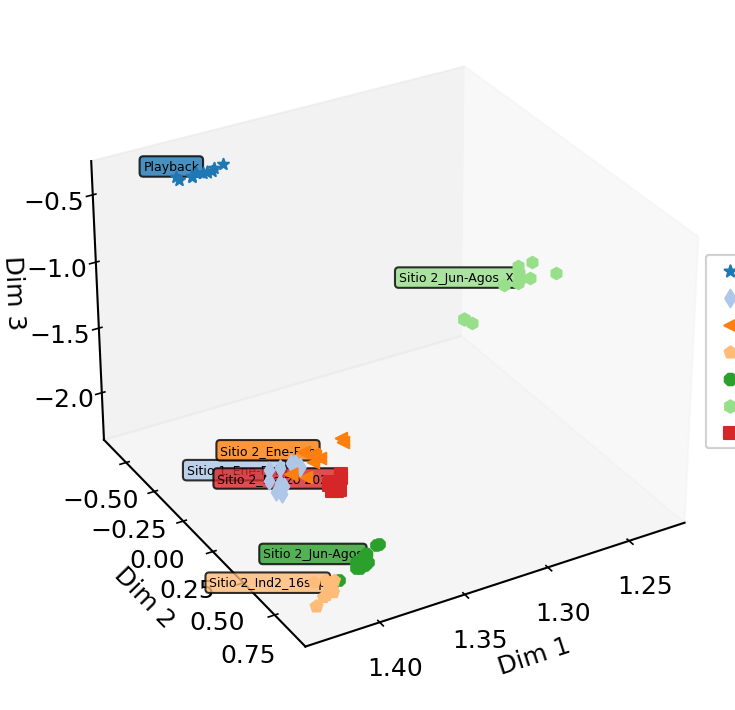

In [14]:
m_styles = ['*', 'd', '<', 'p', '8', 'h', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's']

clases = np.unique(lista_clases)
colors = sns.color_palette('tab20', 20)
arr_clases=np.array(lista_clases)

angulo_1 = 30
angulo_2 = 60

plt.rcParams['axes.linewidth'] = 1.0
fig = plt.figure(figsize=(8,4.8), dpi=150)
ax = plt.axes(projection='3d')

for clases in range(len(clases)):
  val = np.where(arr_clases == clases)
  x,y,z=np.mean(lista_coordenadas[val[0][:],0]), np.mean(lista_coordenadas[val[0][:],1]), np.mean(lista_coordenadas[val[0][:],2])
  for i in range(len(val[0])):
    if i<len(val[0])-1:
      ax.scatter(lista_coordenadas[val[0][i],0], lista_coordenadas[val[0][i],1], lista_coordenadas[val[0][i],2],
                 color=colors[clases], s=30, marker=m_styles[clases])
  ax.scatter(lista_coordenadas[val[0][i],0], lista_coordenadas[val[0][i],1], lista_coordenadas[val[0][i],2],
             color=colors[clases], label=str(folder_list[clases]), s=35, marker=m_styles[clases])
  texto= str(folder_list[clases])
  ax.text(x,y,z, texto, size=6, color='k', ha = 'right', va = 'bottom',
          bbox = dict(boxstyle = 'round,pad=0.3', fc = colors[clases], alpha = 0.8))
legend = ax.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), fontsize='small')
ax.add_artist(legend)

ax.set_xlabel('Dim 1', size=12)
ax.set_ylabel('Dim 2', size=12)
ax.set_zlabel('Dim 3', size=12)
ax.tick_params(labelsize=12, length=20, width=14)
ax.grid(False)
plt.tight_layout()
ax.view_init(angulo_1, angulo_2)
# plt.savefig('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Resultados/'+ Nombre + '_3D' + '.svg',
#             dpi=150, facecolor='w', edgecolor='w', orientation='portrait', format="svg",
#             transparent=False, pad_inches=0.1, bbox_inches= None) #bbox_inches=None
plt.show()

Varianza muestral por componente principal: [0.9823 0.0141]
Componentes =  2 ; Varianza total explicada =  99.64 %


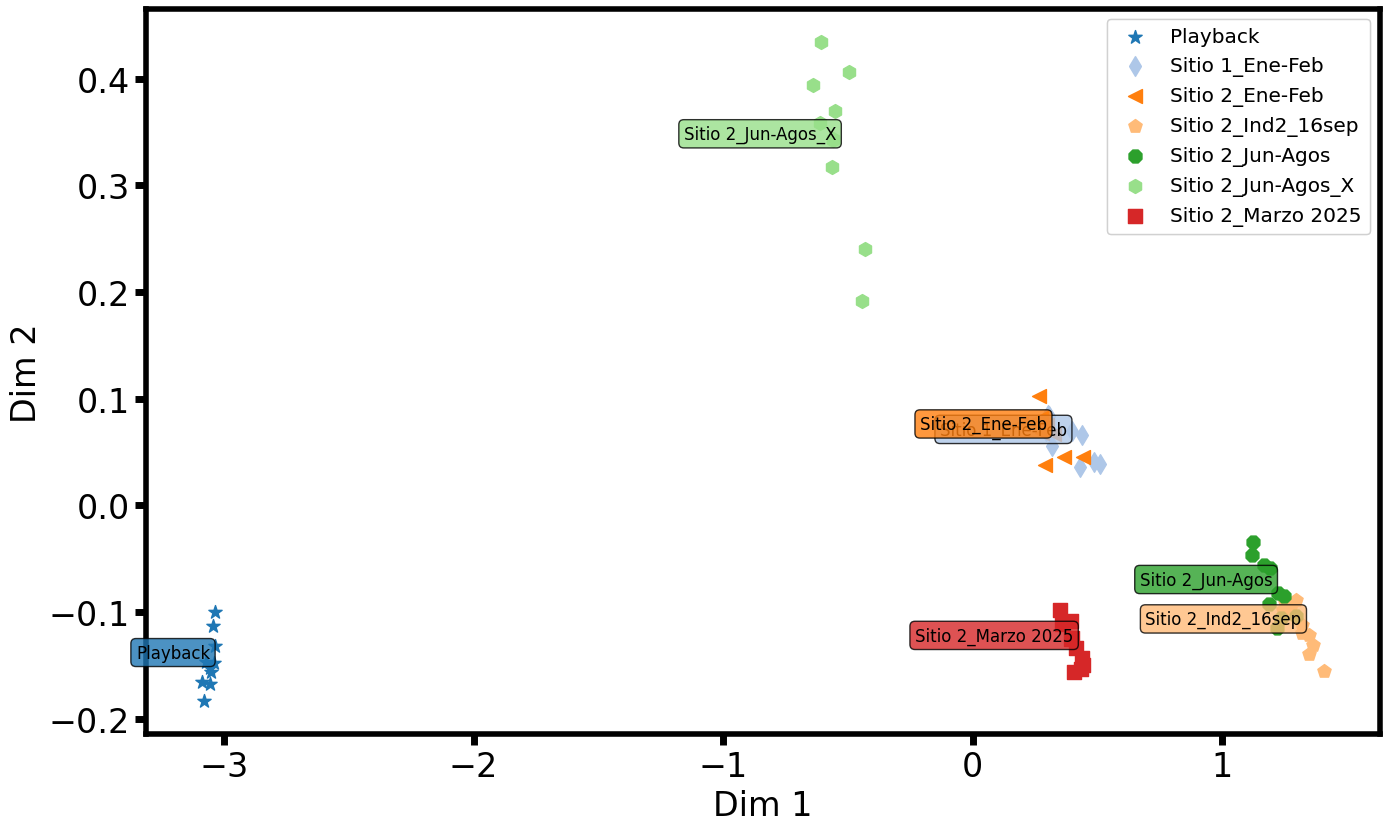

In [15]:
np.set_printoptions(precision=4, suppress=True)

pca = PCA(2)
reduccion_2D = pca.fit_transform(lista_coordenadas)
print("Varianza muestral por componente principal: {}".format(pca.explained_variance_ratio_))
print("Componentes = ", pca.n_components_ , "; Varianza total explicada = ",
      "%.2f" % round(pca.explained_variance_ratio_.sum()*100,5), '%')

# m_styles = [r"$\mathcal{P}$", r"$\mathcal{R}$", r"$\mathcal{G}$", 'd', r"$\mathcal{W}$"]

m_styles = ['*', 'd', '<', 'p', '8', 'h', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's']
clases = np.unique(lista_clases)

colors = sns.color_palette('tab20', 20)
arr_clases=np.array(lista_clases)
#----------------------------------------------------------------
plt.rcParams['axes.linewidth'] = 4.0
fig, ax = plt.subplots(figsize=(14,8.43))
ax = fig.gca()

for clases in range(len(clases)):
  val = np.where(arr_clases == clases)
  x,y=np.mean(reduccion_2D[val[0][:],0]), np.mean(reduccion_2D[val[0][:],1])
  for i in range(len(val[0])):
    if i<len(val[0])-1:
      ax.scatter(reduccion_2D[val[0][i],0], reduccion_2D[val[0][i],1], color=colors[clases], s=100, marker=m_styles[clases])
  ax.scatter(reduccion_2D[val[0][i],0], reduccion_2D[val[0][i],1], color=colors[clases], label=str(folder_list[clases]), s=100,
             marker=m_styles[clases])
  texto= str(folder_list[clases])
  ax.text(x, y, texto, size=12, color='k', ha = 'right', va = 'bottom',
          bbox = dict(boxstyle = 'round,pad=0.3', fc = colors[clases], alpha = 0.8))
legend = ax.legend(loc="best", fontsize='x-large')
ax.add_artist(legend)

ax.set_xlabel('Dim 1', size=24)
ax.set_ylabel('Dim 2', size=24)
ax.tick_params(labelsize=24, length=8, width=5)
ax.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Resultados/'+ Nombre + '_2D' + '.svg', dpi=1200, facecolor='w', edgecolor='w',
#             orientation='portrait', format="svg",
#             transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

In [ ]:
np.savetxt('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Resultados/' + Nombre + '_Coordenadas3D_Inseminado.txt', lista_coordenadas)
np.savetxt('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Resultados/' + Nombre + '_Coordenadas2D_Inseminado.txt', reduccion_2D)
np.savetxt('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Resultados/' + Nombre + '_Clases_Inseminado.txt', lista_clases)